# Reche d'un modèle optimal

Nous allons dans ce notebook décrire les différentes étapes de la séléction, de l'entrainement et de l'optimisation d'un modèle. Nous avons initiallement retenue un certain nombres de features suite à la phase d'analyse exploratoire dese donnés.

### Chargement des scripts du projet et de la config

In [2]:
import yaml
import numpy as np

from subscription_forecast.domain import model_evaluation
from subscription_forecast.domain.model_evaluation import ModelEvaluator
from subscription_forecast.domain import feature_engineering
from subscription_forecast.infrastructure import preprocessing

In [3]:
config_path ="../config/config.yml"

In [4]:
with open(config_path, 'r') as file_in:
    CONFIG = yaml.safe_load(file_in)

In [5]:
TARGET = CONFIG['filters']['TARGET']
features_to_drop = CONFIG['filters']['features_to_drop']

## Choix de critères d'évaluation

Premièrement il nous fallait décider de critères pour évaluer la performance de notre modèle. Il nous a paru important de faire attention aux nombre de <b> vrai positifs </b> et de <b> faux négatifs </b>, en d'autre termes: combien d'acheteurs potentiels ont été identifiés par le modèle, et combien on été raté. Il semble plus important de ne pas rater d'acheteurs, plutôt que d'appeler trop de clients.


Pour celà, nous avons décider de s'intéresser à la <b> precision </b> et au <b> recall </b>. En particulier, nous nous interesseront à la courbe precision/recall. Pour comparer la performance de nos modèle, nous comparerons les valeurs de l'aire sous la courbe precision/rerall (<b> Precision/Recall AUC </b>).

## Choix d'un algorythme d'apprentissage

Nous voulions avant tout avoir un modèle de classification facilement explicable. Nous sommes donc parti sur 2 types d'algorithmes:     <br>
- La Régression Logistique
- Le Random Forest

A chaque étape du feature engineering, nous avons comparé la régression logistique et le random forest. Pour chaque configuration, les performances du random forest étaient bien meilleures. 

### Regression logistique après feature engineering:

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#### Preprocessing des datas:

In [7]:
client_full = preprocessing.features_from(CONFIG['training_data']['data_path'],
                                          CONFIG['training_data']['client_file_name'],
                                          CONFIG['training_data']['socio_eco_file_name'],
                                          features_to_drop)

#### Préparation du train set et du test pour évaluer le modèle:

In [8]:
y = client_full[TARGET]
y = y.replace({'Yes': 1, 'No': 0})
x = client_full.drop(columns=TARGET)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### Fit du pipeline de régression logistique

In [9]:
MODEL_NAME = 'lr'

final_pipeline = Pipeline(steps=[
        ('transformer', feature_engineering.transformer),
        (MODEL_NAME, LogisticRegression())])

final_pipeline.fit(x_train, y_train);

#### Evaluation des performances du modèle obtenu:

Model train accuracy :  0.893
Model accuracy :  0.89
Model precision :  0.583
Model recall =  0.187
Confusion Matrix : 
 [[ 197  854]
 [ 141 7836]]
AUC precision recall curve is :  0.408


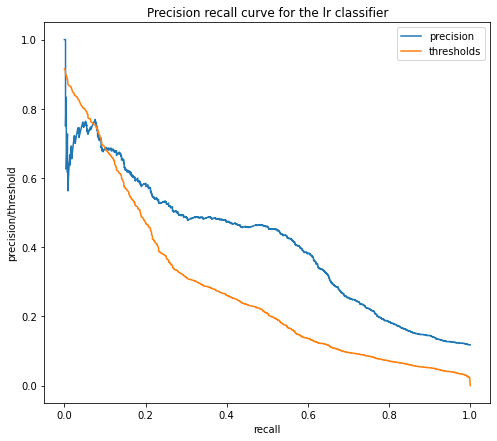

In [10]:
evaluator = ModelEvaluator(MODEL_NAME, final_pipeline)

evaluator.print_metrics(x_test, y_test, x_train, y_train)
evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Nous obtenons ici 2 choses importantes: <br>
- Les métriques de performance du modèle avec le seuil (threshold) naturel de 0.5
- La courbe de precision recall liée à la variation du seuil
<br>

Nous reparleront plus tard de l'importance de toutes ces métriques, étudions maintenant le Random Forest.

### Résultats avec le Random Forest

In [11]:
MODEL_NAME = 'rf'

final_pipeline = Pipeline(steps=[
        ('transformer', feature_engineering.transformer),
        (MODEL_NAME, RandomForestClassifier(random_state=12, n_estimators=100, max_depth=5))])

final_pipeline.fit(x_train, y_train);

#### Evaluation des performances du Random Forest

Model train accuracy :  0.896
Model accuracy :  0.895
Model precision :  0.707
Model recall =  0.167
Confusion Matrix : 
 [[ 176  875]
 [  73 7904]]
AUC precision recall curve is :  0.442


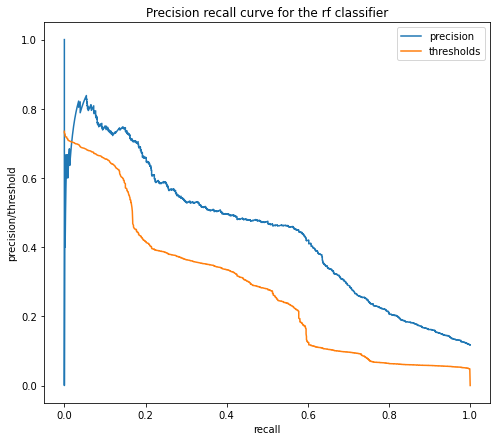

In [12]:
evaluator = ModelEvaluator(MODEL_NAME, final_pipeline)

evaluator.print_metrics(x_test, y_test, x_train, y_train)
evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Avec des hyper paramètres non optimisés, nous observons que le Random forest a une meilleure air sous la courbe (AUC) que la régression logistique, ce qui nous interesse particulièrement. Il a égallement une précision plus élevée, mais un recall légèremnt plus faible. <br> 

A première vue et sans optimisation, le random forest semble plus performant. De plus, en observant les courbes, on voit que dans les 2 cas, il y a un "coude" à partir du quel la couurbe diminue fortement. Ce "coude" apparait pour des valeurs plus élevés pour le Random Forest. Celà signifie qu'en diminueant le seuil (courbe en orange), le rapport entre la precision et le recall sera plus interessant pour le Random Forest. <br>

L'algorithme préférable semble être le Random Forest.

## Choix des features

La phase d'EDA nous a permis de pré sélectionner les features à ne pas garder pour l'optimisation. <br>
De plus Job_type nous n'utiliserons pas job_type. Cette variable semble relativement corréler à la cible, mais malgrès nos efforts nous n'avons pas réussi à augmenter les performances du modèle en l'ajoutant.

In [13]:
print("features non utilisées:")
CONFIG['filters']['features_to_drop']

features non utilisées:


['contact',
 'duration_contact',
 'nb_contact_last_campaign',
 'has_default',
 'job_type']

De nombreuses combinaisons de features et de feature engineering ont été testé sur base de l'augmentation des performance des algorithmes. De plus, l'affichage de l'importance des feature (pour le RF) ou des coefficients (pour le RL) nous a permit d'évaluer leur impact.

#### Exemple pour le random forest:

In [14]:
evaluator.get_feature_importance()

Feature importance: 
 [0.27  0.03  0.104 0.013 0.008 0.001 0.002 0.001 0.002 0.003 0.    0.186
 0.068 0.215 0.049 0.049]


Dans l'ordre, les features retenues sont:
- Result_last_campaign: 1 si succes, 0 pour toues les autre cas
- Age: Nan imputé à la mediane, Robust scaler
- Date: les mois on été extraits de la date puis target encodé
- Balance et Nb_contact : Robust Scaler
- Education et Status: One hot encoder
- Socio_eco features: Robust scaler
- housing_loan and perso_loan : encodé, 2 si les 2 loans sont true, 1 pour 1 loan, 0 sinon
- day_last_contact: transformation 1/x


L'utilisation de ces features nous a permis d'améliorer la performance pour les 2 algorithmes.

## Valeurs manquantes:


Il est possible d'améliorer la prédiction en ne gardant que les observations avec moins de 3 valeurs manquantes après le préprocessing:

In [15]:
client_full, rows_removed = preprocessing.drop_nan(client_full)

Before preprocessing the dataset contains 41274 missing values
After preprocessing the dataset contains 38355 missing values


Afin d'avoir un modèle plus fontionel, nous avons néanmoins décidé de ne pas filtrer les valeurs manquante afin d'être capable d'effectuer des prédictions sur n'importe quel client.

## Optimisation des hyperparamètres:

Enfin, nous avons utilisé le module d'optimisation bayesienne Optuna pour trouver finnir d'améliorer notree modèle. Pour cela, nous avons testé 3 études d'optimisations, chacune cherchant à maximiser une métrique différente: <br>
- Average Precision
- Recall
- f1 score <br>

Nous avons essayé d'optimiser la regression logistique ainsi que le random forest. Ce dernier s'est une fois de plus retrouvé plus performant après optimisation.

les résultats les plus satisfaisant sont obtenues avec l'optimisation de l'"average precision". Cela reste cohérent avec notre objectif d'obtenir la meilleur courbe precision/recall.


In [16]:
 optimal_parameters = {'rf_n_estimators': 668,
                          'rf_max_depth': 10,
                          'rf_min_samples_leaf': 10,
                          'rf_min_samples_split': 31,
                          'rf_bootstrap': True,
                          'rf_max_features': 'auto'}

## Modèle optimisé:

In [17]:
optimal_pipeline = Pipeline(steps=[('transformer', feature_engineering.transformer),
                                 (MODEL_NAME, RandomForestClassifier(random_state=12,
                                            max_depth=optimal_parameters['rf_max_depth'],
                                            n_estimators=optimal_parameters['rf_n_estimators'],
                                            min_samples_leaf=optimal_parameters['rf_min_samples_leaf'],
                                            min_samples_split=optimal_parameters['rf_min_samples_split'],
                                            bootstrap=optimal_parameters['rf_bootstrap'],
                                            max_features=optimal_parameters['rf_max_features']))])

optimal_pipeline.fit(x_train, y_train);

Model train accuracy :  0.901
Model accuracy :  0.896
Model precision :  0.681
Model recall =  0.207
Confusion Matrix : 
 [[ 218  833]
 [ 102 7875]]
AUC precision recall curve is :  0.457


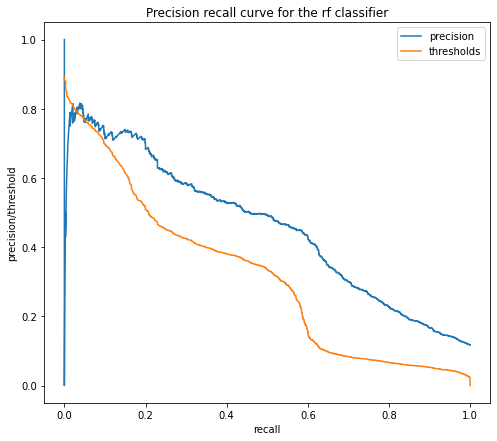

In [18]:
opt_evaluator = ModelEvaluator(MODEL_NAME, optimal_pipeline)

opt_evaluator.print_metrics(x_test, y_test, x_train, y_train)
opt_evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Bien que la précision diminue légèrement, l'aire sous la courbe ainsi que le recall augmente. De plus, la courbe descent "moins vite" quand le seuil diminue, ce qui est très intéressant.

### Choix du seuil:

In [19]:
from sklearn.metrics import recall_score,\
    precision_score, \
    confusion_matrix, \
    accuracy_score

Avec le seuil par défaut de 0.5, la precision est de 0.68 et le recall de 0.192. On observe néanmoins sur la courbe qu'on peut augmenter grandement le recall sans trop perdre en précision en ramenant le seuil vers 0.2

In [20]:
THRESHOLD = 0.2

In [21]:
engineered_data = final_pipeline.steps[0][1].transform(x_test)
predictions_proba = final_pipeline.steps[1][1].predict_proba(engineered_data)

In [22]:
predictions = np.where(predictions_proba[:, 1] >= THRESHOLD, 1, 0)

In [23]:
print("Model accuracy : ", np.around(accuracy_score(y_test, predictions), decimals=3))
print("Model precision : ", np.around(precision_score(y_test, predictions, average="binary", pos_label=1), decimals=3))
print("Model recall = ", np.around(recall_score(y_test, predictions, average="binary", pos_label=1), decimals=3))
print("Confusion Matrix : \n", confusion_matrix(y_test, predictions, labels=[1, 0]))

Model accuracy :  0.867
Model precision :  0.445
Model recall =  0.578
Confusion Matrix : 
 [[ 607  444]
 [ 758 7219]]


Avec un seuil de 0.2, on obtient une precision de 0.445 pour un recall de 0.578. Intéressont nous à la matrice de confusion
En terme de clients appelés, celà signifie que: <br>
- Sur un de total dee 1051 clients qui ont souscrits, 607 ont été appelé (contre 218 avec le seuil de 0.5), 444 n'ont pas été appelés.
- 758 client qui ne souscrivent pas n'ont pas été appelés.
- 7219 clients qui ne souscrivent pas n'ont pas été appelés. <br>
 